# AI route finder using an agenda-based search algorithm- London Underground Project
- Date: 08/09/2023
- Author: Ziad Tamim
- Description:
Building an AI route finder for the London Tube system using an agenda-based search mechanism. 

Project Tasks:
* Implement DFS, BFS, and UCS.
* Compare DFS, BFS, and UCS across various metrics.
* Extend the cost function to include time for changing lines.
* Implement a heuristic Best-First Search and compare it to UCS.

In [44]:
# Imports
import pandas as pd
from collections import deque
import heapq
from collections import defaultdict

# Loading the Dataset
* Use Pandas `read_csv()`  to read CSV file
* Initilise two dictionaries, one for storing stations and the other one for storing zones.
* Iterate over each row in the DataFrame and store the data


In [45]:
df = pd.read_csv('tubedata.csv', header=None)
df.head()

# Initialize two defaultdict objects
station_dict = defaultdict(list)
zone_dict = defaultdict(set)

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Extract information from the current row
    start_station = row[0]
    end_station = row[1]
    line = row[2]  # Extract the line information
    act_cost = int(row[3])
    zone1 = row[4]
    zone2 = row[5]
    
    # Update the station_dict with the children stations and costs
    station_list = station_dict[start_station]
    station_list.append((end_station, act_cost, line))
    
    # Add the reverse direction since the Tube is bidirectional
    station_list = station_dict[end_station]
    station_list.append((start_station, act_cost, line))
    
    # Update the zone_dict with the zones of each station
    zone_dict[start_station].add(zone1)
    if zone2 != "0":
        zone_dict[start_station].add(zone2)
        zone_dict[end_station].add(zone2)
    else:
        zone_dict[end_station].add(zone1)

## Visalising the data using NetworkX package

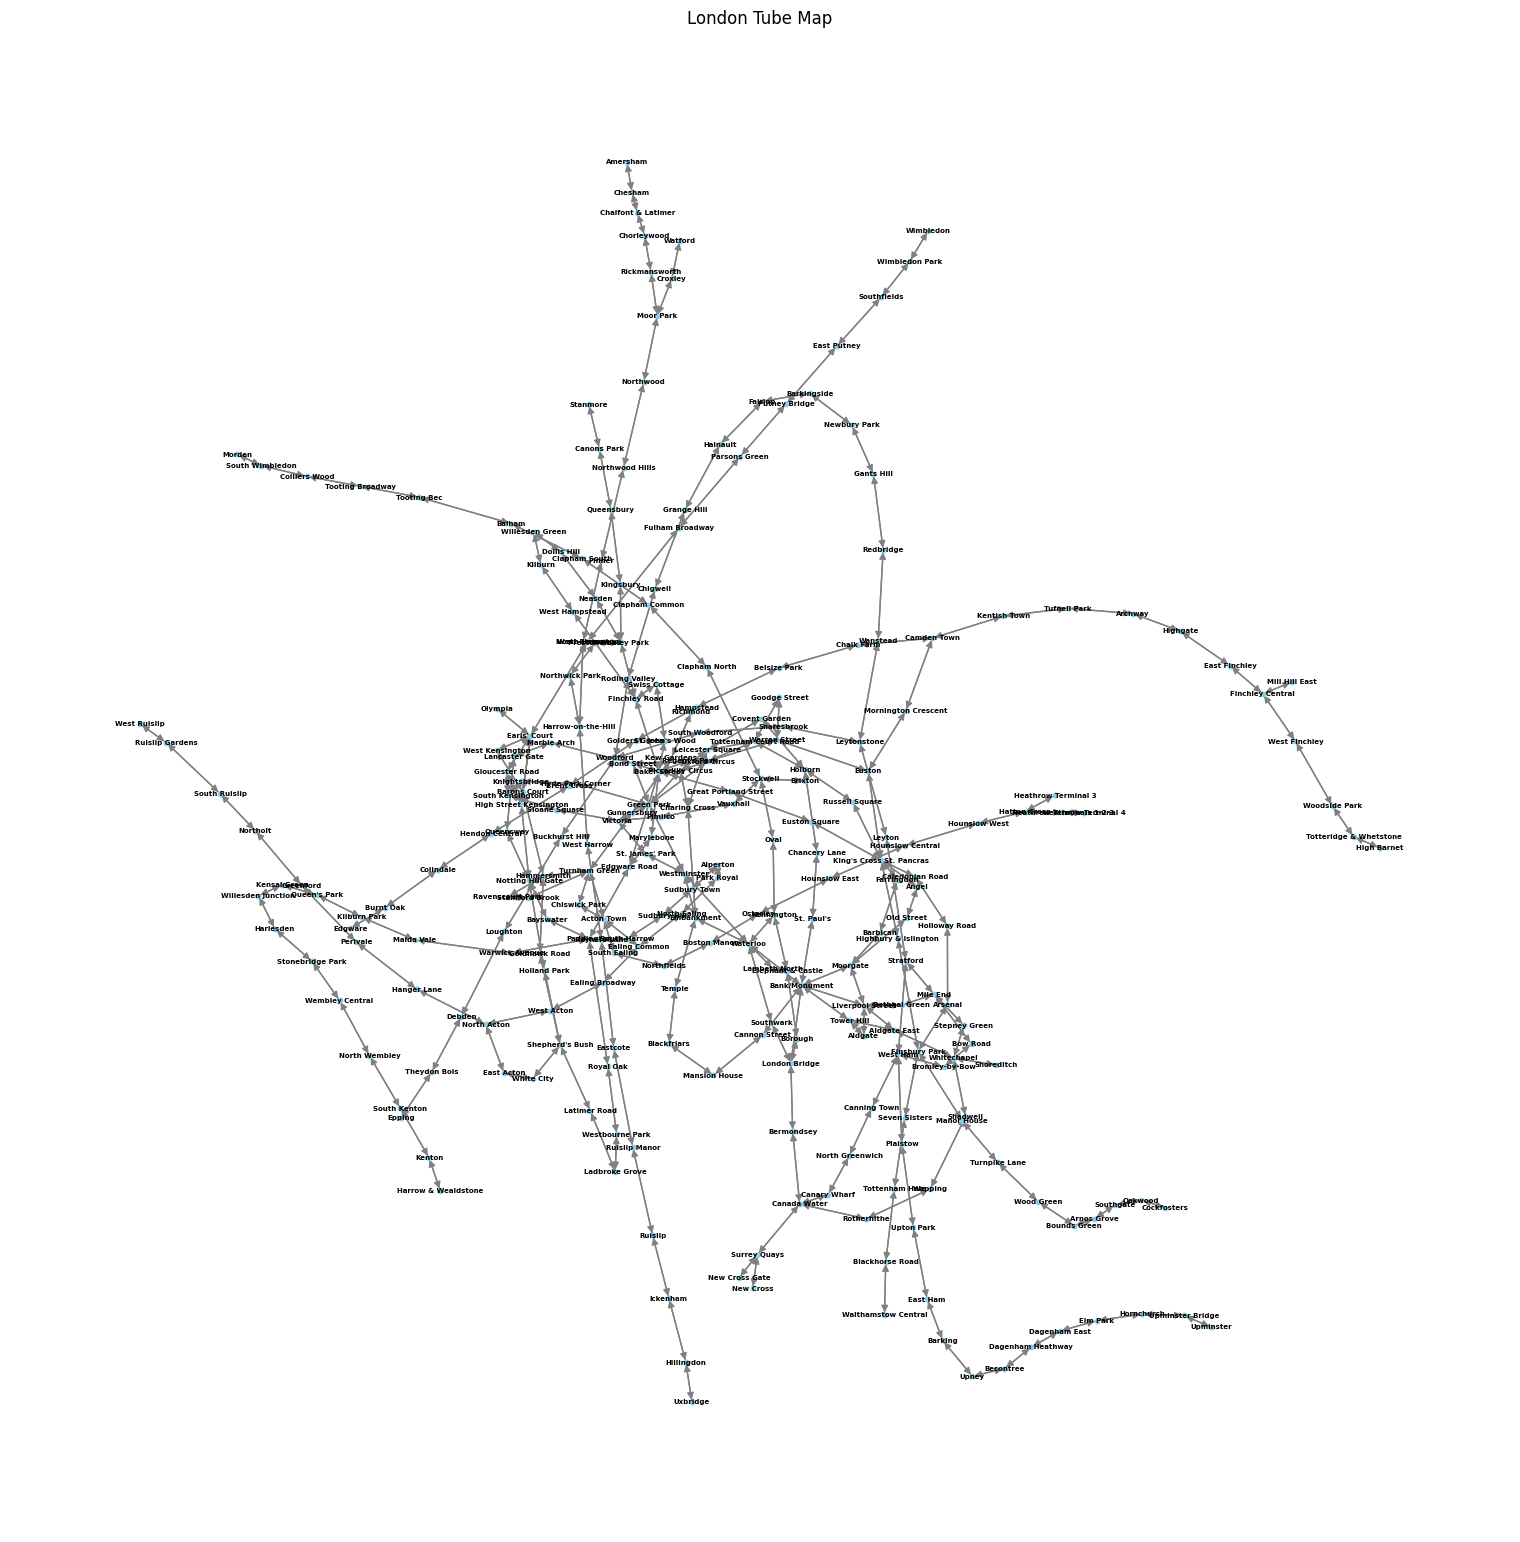

In [46]:
# Visualising the data using NetworkX
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph object
G = nx.DiGraph()

# Iterate over each station in the station_dict
for station, children in station_dict.items():
    # Iterate over each child station
    for child, cost, line in children:
        # Add an edge between the station and the child station
        G.add_edge(station, child, weight=cost, line=line)

# Draw the graph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=10, node_color="skyblue", font_size=5, font_weight="bold", font_color="black", edge_color="gray", linewidths=1, arrowsize=10)
plt.title("London Tube Map")
plt.show()


# Agenda-based search

In [47]:
# Define the station names starting and ending stations
starting_station = "Mile End"
ending_station = "Oxford Circus"


## Breadth First Search
Breadth-First Search (BFS) is an algorithm used to explore or search through a graph by systematically exploring all neighboring nodes at the present depth before moving on to nodes at the next depth level. It starts from a source node, explores all its direct neighbors first, then moves to their neighbors, continuing this process level by level. BFS guarantees finding the shortest path (in terms of the number of steps) in an unweighted graph, but it doesn't account for varying costs or distances between nodes. It uses a queue data structure to manage the exploration process.

In [48]:
def bfs(start, goal, graph):
    queue = deque([start])  # Initialize the queue with the start position
    path_cost = {start: 0}  # Keep track of the path cost in stations
    time_cost = {start: 0}  # Keep track of the cost in average time
    nodes_expanded = 0  # Keep track of the number of nodes expanded
    parent = {start: None}  # Keep track of the parent of each node to reconstruct the path

    while queue:
        # Dequeue the next node to explore
        current_station = queue.popleft()
        nodes_expanded += 1

        # Check if we've reached the goal
        if current_station == goal:
            # Reconstruct the path and calculate the total cost
            path = []
            while current_station:
                path.append(current_station)
                current_station = parent[current_station]
            path.reverse()

            # Get the path cost in stations for the goal
            stations_path_cost = path_cost[goal]
            return path, stations_path_cost, time_cost[goal], nodes_expanded

        # Check the neighbors of the current node
        for child in graph[current_station]:
            child_station, child_cost, _ = child
            if child_station not in path_cost:
                path_cost[child_station] = path_cost[current_station] + 1 # Calculate the path cost in stations
                time_cost[child_station] = time_cost[current_station] + child_cost # Calculate the cost in average time
                parent[child_station] = current_station # Set the parent for path reconstruction
                queue.append(child_station) # Enqueue the child to explore it later

    return None, None, None, nodes_expanded 

# Example usage
path, stations_path_cost, time, expanded = bfs(starting_station, ending_station, station_dict) 
print("____Breadth-First Search____")
print("Path:", path) 
print("Path cost in stations:", stations_path_cost) 
print("Total cost in average time:", time)
print("Number of nodes expanded:", expanded)

____Breadth-First Search____
Path: ['Mile End', 'Bethnal Green', 'Liverpool Street', 'Bank/Monument', 'Waterloo', 'Westminster', 'Green Park', 'Oxford Circus']
Path cost in stations: 7
Total cost in average time: 18
Number of nodes expanded: 70


## Depth First Search
Depth-First Search (DFS) is a graph traversal algorithm that explores as far down a branch or path as possible before backtracking to explore other branches. It starts at a source node and dives deep into one path until it reaches the end or a visited node, then backtracks to explore alternative paths. DFS uses a stack data structure (either explicitly or via recursion) and does not guarantee the shortest path in terms of steps or cost, but it is efficient for exploring deep, complex graphs.

In [49]:
def dfs(start, goal, graph):
    stack = [(start, 0, 0)]  # Each stack element is (station, path_cost, time_cost)
    visited = set()  # Keep track of visited nodes
    nodes_expanded = 0  # Number of nodes expanded
    parent = {start: None}  # Parent mapping for path reconstruction
    
    while stack:
        # Pop the last node (LIFO)
        current_station, path_cost, time_cost = stack.pop()
        nodes_expanded += 1
        
        if current_station not in visited:
            visited.add(current_station)
            
            # Check if the goal has been reached
            if current_station == goal:
                # Reconstruct the path from goal to start using the parent mapping
                path = []
                while current_station:
                    path.append(current_station)
                    current_station = parent[current_station]
                path.reverse()  # The path is reconstructed from goal to start so we need to reverse it
                return path, path_cost, time_cost, nodes_expanded
            
            # If current node is not the goal, explore its children
            for child_station, child_time_cost, _ in graph[current_station]:
                if child_station not in visited:
                    stack.append((child_station, path_cost + 1, time_cost + child_time_cost))
                    parent[child_station] = current_station  # Set the parent for path reconstruction
    
    # If the goal is not reachable, return None
    return None, None, None, nodes_expanded

path, stations, time, expanded = dfs(starting_station, ending_station, station_dict) # dfs('Start_Station', 'End_Station', station_dict)
print("____Depth First Search____")
print("Path:", path)
print("Path cost in stations:", stations)
print("Cost in average time:", time)
print("Number of nodes expanded:", expanded)

____Depth First Search____
Path: ['Mile End', 'Bow Road', 'Bromley-by-Bow', 'West Ham', 'Canning Town', 'North Greenwich', 'Canary Wharf', 'Canada Water', 'Bermondsey', 'London Bridge', 'Borough', 'Elephant & Castle', 'Kennington', 'Oval', 'Stockwell', 'Vauxhall', 'Pimlico', 'Victoria', 'Green Park', 'Oxford Circus']
Path cost in stations: 19
Cost in average time: 43
Number of nodes expanded: 43


## Uniformed Cost Search
Uniform Cost Search (UCS) is a search algorithm that expands the least-cost node first, making it an optimal algorithm for finding the path with the lowest total cost in a weighted graph. It uses a priority queue to explore nodes based on their cumulative path cost from the starting node, ensuring that nodes with the lowest cost are explored first. Unlike BFS, which considers the shortest number of steps, UCS takes into account varying edge costs and guarantees the optimal path in terms of cost, provided all edge costs are non-negative.

In [50]:
def ucs(start, goal, graph):
    # Priority queue: elements are tuples of (total_time_cost, current_station, path_cost, path)
    priority_queue = [(0, start, 0, [])]  # (time cost, station, station count, path)
    visited = set()  # Keep track of visited nodes
    nodes_expanded = 0  # Number of nodes expanded
    
    while priority_queue:
        # Pop the node with the lowest cost
        current_time_cost, current_station, path_cost, path = heapq.heappop(priority_queue)
        nodes_expanded += 1

        if current_station not in visited:
            visited.add(current_station)
            path = path + [current_station]

            # Check if the goal has been reached
            if current_station == goal:
                return path, path_cost, current_time_cost, nodes_expanded

            # If current node is not the goal, explore its children
            for child_station, child_time_cost, _ in graph[current_station]:
                if child_station not in visited:
                    new_cost = current_time_cost + child_time_cost
                    heapq.heappush(priority_queue, (new_cost, child_station, path_cost + 1, path))
    
    # If the goal is not reachable, return None
    return None, None, None, nodes_expanded

# Example usage:
path, stations, time, expanded = ucs(starting_station, ending_station, station_dict)
print("____Uniformed Cost Search____")
print("Path:", path)
print("Path cost in stations:", stations)
print("Cost in average time:", time)
print("Number of nodes expanded:", expanded)

____Uniformed Cost Search____
Path: ['Mile End', 'Bethnal Green', 'Liverpool Street', 'Bank/Monument', "St. Paul's", 'Chancery Lane', 'Holborn', 'Tottenham Court Road', 'Oxford Circus']
Path cost in stations: 8
Cost in average time: 16
Number of nodes expanded: 119


## Uniformed Cost Search with extra cost for line change
To extend the UCS cost function, I add a line-changing penalty (e.g., 2 minutes) whenever a traveler switches Tube lines at a station. This adjustment ensures that the search algorithm accounts not only for travel time between stations but also for the time spent changing lines. The modified UCS will prioritize routes with fewer line changes when alternative paths have similar travel times.

In [51]:
def ucs(start, goal, graph, line_change_cost=10):
    priority_queue = [(0, start, 0, None)]  # Include the last line as None initially
    visited = set()
    nodes_expanded = 0
    parent = {start: None}

    while priority_queue:
        time_cost, current_station, path_cost, last_line = heapq.heappop(priority_queue)
        nodes_expanded += 1

        if current_station not in visited:
            visited.add(current_station)

            if current_station == goal:
                path = []
                while current_station:
                    path.append(current_station)
                    current_station = parent[current_station]
                path.reverse()
                return path, path_cost, time_cost, nodes_expanded

            for child_station, child_time_cost, child_line in graph[current_station]:
                if child_station not in visited:
                    total_cost = time_cost + child_time_cost

                    # Add line change cost if the line changes
                    if last_line and child_line != last_line:
                        total_cost += line_change_cost
                        

                    heapq.heappush(priority_queue, (total_cost, child_station, path_cost + 1, child_line))
                    parent[child_station] = current_station

    return None, None, None, nodes_expanded

# Example usage
path, stations, time, expanded = ucs(starting_station, ending_station, station_dict)
print("Path:", path)
print("Path cost in stations:", stations)
print("Cost in average time:", time)
print("Number of nodes expanded:", expanded)


Path: ['Mile End', 'Bethnal Green', 'Liverpool Street', 'Bank/Monument', "St. Paul's", 'Chancery Lane', 'Holborn', 'Tottenham Court Road', 'Oxford Circus']
Path cost in stations: 8
Cost in average time: 16
Number of nodes expanded: 34


## Heuristic Search (Best-First Search, Not A*)
Heuristic Search (Best-First Search) is a search algorithm that uses a heuristic function to guide the search toward the goal. It selects the next node to explore based on the estimated cost (heuristic) to reach the goal, focusing on the most promising nodes first. Unlike A*, Best-First Search only considers the heuristic estimate, not the path cost from the start. It can be faster than UCS but may not guarantee the optimal solution because it doesn't account for the total cost of the path, only the proximity to the goal.

In [52]:
def heuristic_bfs(start, goal, graph, zone_dict):
    priority_queue = [(0, start)]  # Priority queue of (heuristic value, station)
    visited = set()
    nodes_expanded = 0
    parent = {start: None}
    path_cost = {start: 0}  # Path cost in stations
    time_cost = {start: 0}  # Cost in average time

    # Heuristic function based on zone difference
    def heuristic(station):
        goal_zone = int(list(zone_dict[goal])[0])  # Convert to integer
        station_zones = zone_dict[station]
        return min(abs(goal_zone - int(zone)) for zone in station_zones)  # Convert each zone to integer

    while priority_queue:
        _, current_station = heapq.heappop(priority_queue)
        nodes_expanded += 1

        if current_station not in visited:
            visited.add(current_station)

            if current_station == goal:
                path = []
                while current_station:
                    path.append(current_station)
                    current_station = parent[current_station]
                path.reverse()
                return path, path_cost[goal], time_cost[goal], nodes_expanded

            for child_station, child_time_cost, _ in graph[current_station]:
                if child_station not in visited:
                    heapq.heappush(priority_queue, (heuristic(child_station), child_station))
                    parent[child_station] = current_station
                    path_cost[child_station] = path_cost[current_station] + 1
                    time_cost[child_station] = time_cost[current_station] + child_time_cost

    return None, None, None, nodes_expanded

# Example usage
path, stations_cost, avg_time_cost, expanded = heuristic_bfs(starting_station, ending_station, station_dict, zone_dict)
print("Path:", path)
print("Path cost in stations:", stations_cost)
print("Cost in average time:", avg_time_cost)
print("Number of nodes expanded:", expanded)


Path: ['Mile End', 'Bethnal Green', 'Liverpool Street', 'Bank/Monument', 'Moorgate', 'Barbican', 'Farringdon', "King's Cross St. Pancras", 'Euston Square', 'Great Portland Street', 'Baker Street', 'Bond Street', 'Green Park', 'Oxford Circus']
Path cost in stations: 13
Cost in average time: 30
Number of nodes expanded: 58
